In [1]:
ga_update = 1

In [2]:
if ga_update:
  !pip install deap
  !git clone https://github.com/senolakkas/sklearn-optimize
  !mv sklearn-optimize/ sklearn_genetic/

     |████████████████████████████████| 163kB 6.8MB/s 
Cloning into 'sklearn-optimize'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29
Unpacking objects: 100% (29/29), done.


## Importación de librerías

In [11]:
import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from scipy.io import arff
import random
from collections import OrderedDict
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
## sklearn-optimize es tomado de: https://github.com/senolakkas/sklearn-optimize
from sklearn_genetic.genetic import GeneticSearchCV
from deap import base, creator, tools, algorithms
from sklearn.base import clone, is_classifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
from tabulate import tabulate
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
# GeneticSearchCV modificado
class GeneticSearchCVMod(GeneticSearchCV):
     def __init__(self, estimator, params, scoring=None, cv=4,
                 refit=True, verbose=False, population_size=50,
                 gene_mutation_prob=0.1, gene_crossover_prob=0.5,
                 tournament_size=3, generations_number=10, gene_type=None,
                 n_jobs=1, iid=True, error_score='raise',
                 fit_params={}):
        super(GeneticSearchCV, self).__init__(
            estimator=estimator, scoring=scoring,
            iid=iid, refit=refit, cv=cv, verbose=verbose,
            error_score=error_score)
        self.fit_params=fit_params
        self.params = params
        self.population_size = population_size
        self.generations_number = generations_number
        self._individual_evals = {}
        self.gene_mutation_prob = gene_mutation_prob
        self.gene_crossover_prob = gene_crossover_prob
        self.tournament_size = tournament_size
        self.gene_type = gene_type
        self.all_history_, self.all_logbooks_ = [], []
        self._cv_results = None
        self.best_score_ = None
        self.best_params_ = None
        self.score_cache = {}
        self.n_jobs = n_jobs
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, est=clone(self.estimator), fitness=creator.FitnessMax)

## Lectura de modelos guardados

In [2]:
param_ga = {"kernel": ["rbf", "sigmoid", "linear"],
             "C": np.logspace(-2, 2, num=10, base=10),
             "gamma": np.logspace(-2, 2, num=10, base=10)}
cv_svm_ga_model = GeneticSearchCVMod(estimator=SVC(probability=True),
                     params=param_ga,
                     scoring="recall",
                     cv=StratifiedKFold(n_splits=4),
                     verbose=1,
                     population_size=20,
                     gene_mutation_prob=0.10,
                     gene_crossover_prob=0.5,
                     tournament_size=3,
                     generations_number=5,
                     n_jobs=4)

NameError: name 'GeneticSearchCVMod' is not defined

In [ ]:
# cargamos los modelos
dt_model = joblib.load(os.path.join('modelos','Modelo_DT.pkl'))
lr_model = joblib.load(os.path.join('modelos','Modelo_LR.pkl'))
rf_model = joblib.load(os.path.join('modelos','Modelo_RF.pkl'))
xgb_model = joblib.load(os.path.join('modelos','Modelo_XGB.pkl'))
#cv_svm_model = joblib.load(os.path.join('modelos','Modelo_SVM.pkl'))
#svm_model = cv_svm_model.best_estimator_
#cs_svm_ga_model = joblib.load(os.path.join('modelos','Modelo_GA_SVM.pkl'))
#svm_ga_model = cs_svm_ga_model.best_estimator_

## Lectura de dataset imputado

In [4]:
# se carga dataset imputado
imputed_df = pd.read_pickle(os.path.join('results','dataset_normalizado.pkl'))

In [5]:
# función para separar las columnas en variables y etiquetas ('flag')
def split_features_labels(df):
    feature_dfs = df.iloc[:, 1:]
    label_dfs = df['flag']
    return feature_dfs, label_dfs

## Evaluación de modelos

In [6]:
# Validación cruzada mediante K-fold estratificado
def kfold_cv(k, X, y, verbose=False):
    X = X.values  # Variables
    y = y.values  # Etiquetas
    kf = StratifiedKFold(n_splits=k, shuffle=False, random_state=42)
    # inicializamos los sets vacios
    X_train = [] 
    y_train = []
    X_test = []
    y_test = []
    # usamos el split 
    for train_index, test_index in kf.split(X,y):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test
# seteamos la semilla para tener valores random predecibles
seed = 7

In [15]:
def save_and_show_resultados(descripcion, model, resultados, X_train, X_test, y_train, y_test):
  y_train_pred = model.predict(X_train)
  y_train_pred_proba = model.predict_proba(X_train)[:,1]

  y_test_pred = model.predict(X_test)
  y_test_pred_proba = model.predict_proba(X_test)[:,1]

  confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
  confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

  resultados.update( { descripcion: {
      ('Entrenamiento', 'Exactitud'): model.score(X_train, y_train),
      ('Entrenamiento', 'F1'): f1_score(y_train, y_train_pred),
      ('Entrenamiento', 'AUC'): roc_auc_score(y_train, y_train_pred_proba),
      ('Entrenamiento', 'TypeI'): confusion_matrix_train[0][1],
      ('Pruebas', 'Exactitud'): model.score(X_test, y_test),
      ('Pruebas', 'F1'): f1_score(y_test, y_test_pred),
      ('Pruebas', 'AUC'): roc_auc_score(y_test, y_test_pred_proba),
      ('Pruebas', 'TypeI'): confusion_matrix_test[0][1]
    } } )
  fig, axes = plt.subplots(1, 3, figsize=(18, 5))
  fig.suptitle(f'{descripcion} (Conjunto de Pruebas)')
  plot_confusion_matrix(model, X_test, y_test, ax=axes[0], values_format='d')
  plot_roc_curve(model, X_test, y_test, ax=axes[1], name=descripcion)
  plot_precision_recall_curve(model, X_test, y_test, ax=axes[2], name=descripcion)
  return

In [16]:
def tabla_resultados(resultados):
  df = pd.DataFrame.from_dict(resultados, orient='index')
  display(df)
  return df

In [19]:
# Modelamiento de la data usando un diccionario de datasets y modelos
def perform_data_evaluation(modelos, imputed_df):
    # 7 metricas, usando K-Folds
    # en model_results guardaremos los resultados por clasificador y datasets
    model_results = OrderedDict()
    # to show table
    resultados = {}

    # Iteramos sobre los clasificadores
    for model_name, clf in modelos.items():
        
        # hacemos la division del dataframe en variables y etiquetas
        X, y = split_features_labels(imputed_df)

        # Dividimos la data en test y train
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
                    stratify = y,test_size = 0.2,random_state=1)

        # actualiza resultados
        save_and_show_resultados(model_name, clf, resultados, X_train, X_test, y_train, y_test)

    # presentamos la tabla resumen
    tabla_results = tabla_resultados(resultados)

    return model_results, tabla_results

In [ ]:
# Hacer ranking por cada métrica
def perform_model_ranking_acc(models, imputers, results):
    column_headers = ['-','Accuracy'] 
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['Accuracy'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    results_df.bar()
    return results_df

def perform_model_ranking_f1score(models, imputers, results):
    column_headers = ['-','F1-score']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        recall = model_details['Recalls']
        precision = model_details['Precisions']
        f1score = 2*(recall*precision)/(recall+precision)
        row.append(f1score)
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

def perform_model_ranking_auc(models, imputers, results):
    column_headers = ['-','AUC']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['AUC'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

def perform_model_ranking_typeI(models, imputers, results):
    column_headers = ['-','FP']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['FP'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

## Análisis comparativo

In [9]:
#svm_model.probability=True
# models
models_dictionary2 = OrderedDict()
# models_dictionary2['SVM'] = svm_model
# models_dictionary2['SVM+GA'] = svm_ga_model
models_dictionary2['DT'] = dt_model
models_dictionary2['LR'] = lr_model
models_dictionary2['RF'] = rf_model
#models_dictionary2['XGB'] = xgb_model

**Comparación**

Entrenamiento                             Pruebas                          
       Exactitud        F1       AUC TypeI Exactitud        F1       AUC TypeI
DT      0.927039  0.074419  0.595036   238  0.936950  0.044444  0.628289    44
LR      0.961687  0.045662  0.424268    38  0.958944  0.000000  0.385675    12
RF      0.967736  0.000000  0.811864     0  0.967742  0.000000  0.791822     0

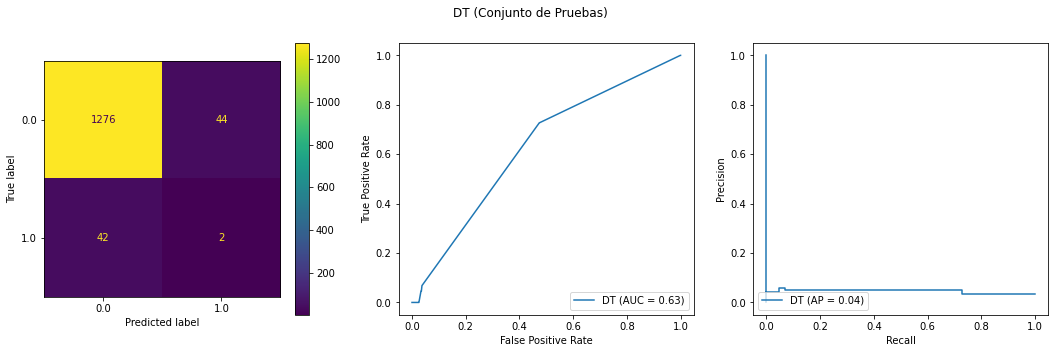

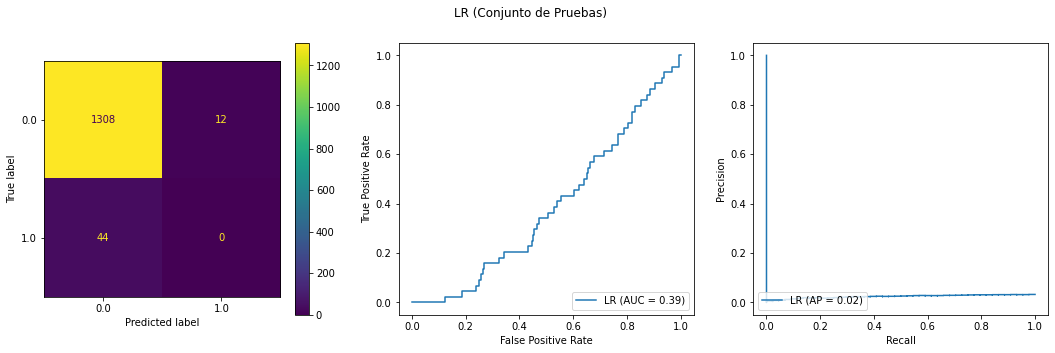

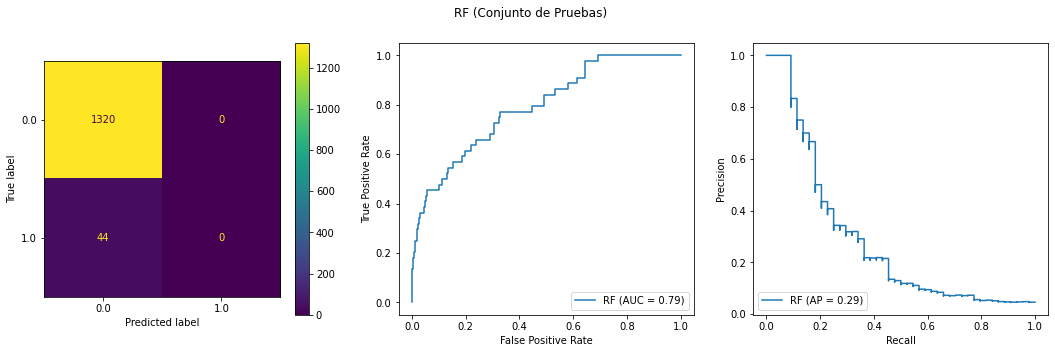

In [20]:
# Verificamos validación para comparación
results, metricas = perform_data_evaluation(models_dictionary2, imputed_df)

**Tablas**

In [49]:
print(metricas.to_latex(index=False))  

\begin{tabular}{rrrrrrrrrr}
\toprule
Entrenamiento & \multicolumn{5}{l}{Pruebas} \\
    Exactitud & Precisión & Exhaustividad &        F1 &       AUC & Exactitud & Precisión & Exhaustividad &        F1 &       AUC \\
\midrule
     1.000000 &  1.000000 &      1.000000 &  1.000000 &  1.000000 &  1.000000 &  1.000000 &      1.000000 &  1.000000 &  1.000000 \\
     1.000000 &  1.000000 &      1.000000 &  1.000000 &  1.000000 &  1.000000 &  1.000000 &      1.000000 &  1.000000 &  1.000000 \\
     0.928336 &  0.068273 &      0.096591 &  0.080000 &  0.604907 &  0.931768 &  0.019608 &      0.022727 &  0.021053 &  0.587609 \\
     0.960227 &  0.098039 &      0.028409 &  0.044053 &  0.421894 &  0.964784 &  0.000000 &      0.000000 &  0.000000 &  0.390775 \\
     0.967742 &  0.000000 &      0.000000 &  0.000000 &  0.790485 &  0.967718 &  0.000000 &      0.000000 &  0.000000 &  0.879178 \\
\bottomrule
\end{tabular}



## Producción de gráficos